In [1]:
%matplotlib inline

%matplotlib inline
%load_ext autoreload
%autoreload 2

import numpy as np

import xarray as xr

import regionmask

import pandas as pd

import matplotlib.pyplot as plt
import cartopy.crs as ccrs
from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
import cartopy.feature as cfeat
import matplotlib.patches as mpatches
import cmocean

import glob
from matplotlib import ticker


import sys
sys.path.append('../')
import utils
import plotting

np.seterr(invalid='ignore'); # disable a warning from matplotlib and cartopy

In [2]:
import string
alphabet = list(string.ascii_lowercase)


# Import Data

In [3]:
ds= xr.open_dataset('./final_data/ds_NOX_SO2_CH2O_daily.nc4')
ds_seasonal = utils.season_mean(ds)
for p in ['NO2','NOx','NO','SO2','CH2O']:
    ds_seasonal[p].attrs = {'units':'ppb'}
    
model_names = ds['model_name'].values


## Mask data to US

In [4]:
#### create a mask ####
states = regionmask.defined_regions.natural_earth.us_states_50
lon = np.arange(230, 300, .25)
lat = np.arange(50, 24, -.125)
mask = states.mask(ds_seasonal, lon_name = 'lon', lat_name = 'lat')
contiguous_mask = ~np.isnan(mask) & (mask != 0.) & (mask != 11) 

#### mask our population dataset ####
ds_seasonal = ds_seasonal.where(contiguous_mask)


# Plots

## US, concentrations

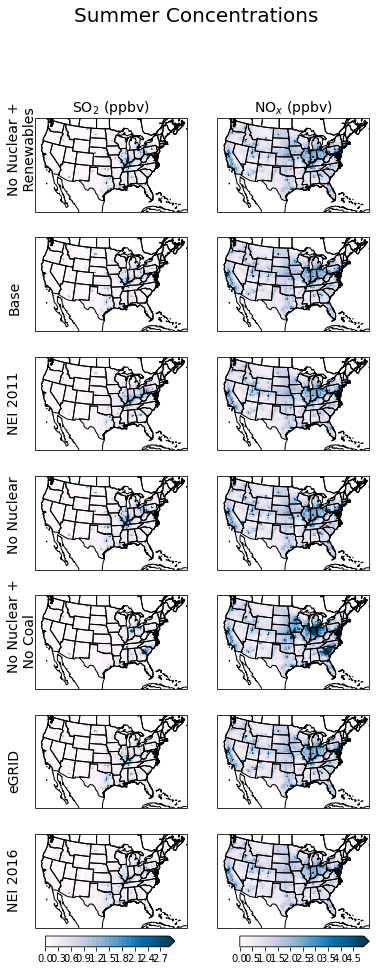

In [5]:
plotting.concentration_plot_seasonal(ds_seasonal = ds_seasonal, species_names = ['SO2','NOx'], season = 'JJA', model_names = model_names,  cmap = plotting.cmap_conc,
                        lat_lon = [-120,-70,20,50], shrink_cbar = 1,
                       figsize = [6,15])
plt.suptitle('Summer Concentrations', fontsize = 20);
plt.savefig('./Figures/supp_summer_conc.png',bbox_inches = 'tight', dpi = 150)

## US, differences

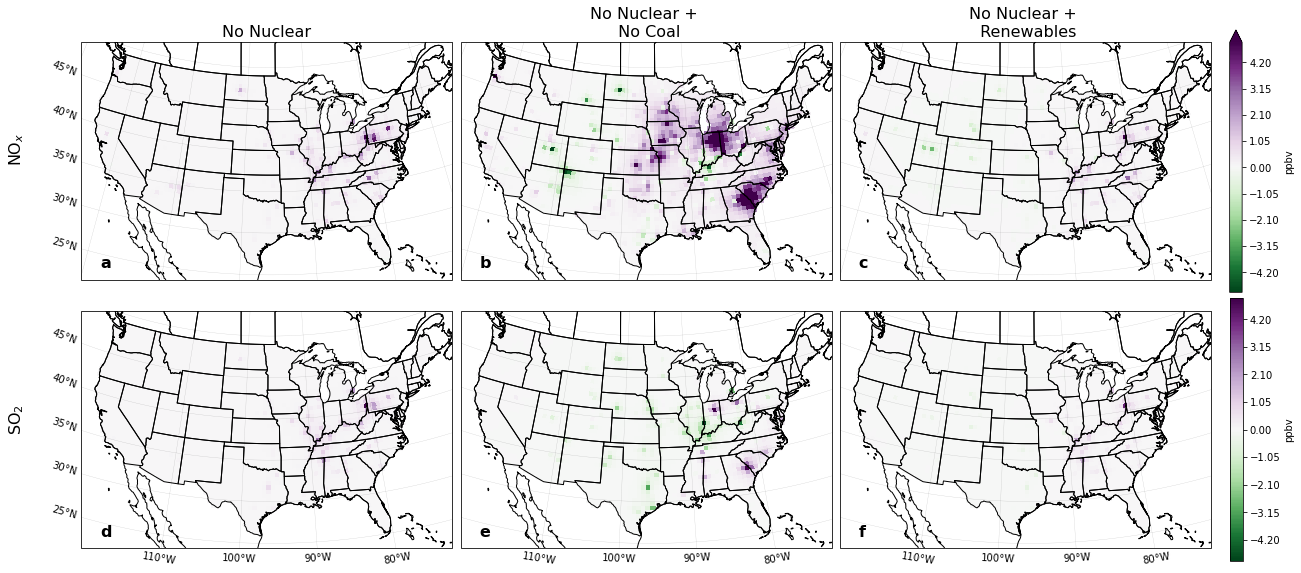

In [6]:
mod_delta = ['nonuc_NA','nonuc_coal_NA','renew_nonuc_NA']
mod_base = 'normal_NA'
cbar_kwargs = {True:{'label':'ppbv'}, False: None}
fig = plt.figure(figsize = [18,8], constrained_layout = True)
alpha_labels = iter(alphabet) 
for idx, md in enumerate(mod_delta):
    ax=fig.add_subplot(2,3,idx+1, projection=ccrs.LambertConformal())
    if idx ==2:
        cbar_arg = True
    else:
        cbar_arg = False
    (ds_seasonal.sel(model_name = md)- 
     ds_seasonal.sel(model_name = mod_base)).mean(dim = 'season')['NOx'].plot(ax = ax, 
                                                                       levels = np.arange(-5.,5.05,.05),
                                                                         cmap = plotting.cmap_dif, 
                                                                        transform=ccrs.PlateCarree(), 
                                                                             add_colorbar = cbar_arg, cbar_kwargs = cbar_kwargs[cbar_arg])
    ax.add_feature(cfeat.STATES)
    ax.coastlines() #add coastlines
    ax.set_extent(plotting.lat_lon) 
    ax.set_title(plotting.proper_model_names_dict[md], fontsize = 16)

    gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, x_inline=False, y_inline=False, linewidth=0.3, color='k',alpha=0.2)
    if idx == 0:
        gl.right_labels = gl.top_labels = gl.bottom_labels = False
    else:
        gl.right_labels = gl.top_labels = gl.bottom_labels = gl.left_labels = False
    if idx == 0:
        ax.text(-0.2, .5, 'NO$_x$', rotation = 'vertical', fontsize = 16, transform=ax.transAxes)
    label = next(alpha_labels)
    ax.text(x = .05, y =.05, s = label, transform=ax.transAxes, fontweight="bold", fontsize = 16)
        
for idx, md in enumerate(mod_delta):
    ax=fig.add_subplot(2,3,idx+4, projection=ccrs.LambertConformal())
    if idx ==2:
        cbar_arg = True
    else:
        cbar_arg = False
    (ds_seasonal.sel(model_name = md)- 
     ds_seasonal.sel(model_name = mod_base)).mean(dim = 'season')['SO2'].plot(ax = ax, 
                                                                       levels = np.arange(-5.,5.05,.05),
                                                                         cmap = plotting.cmap_dif, 
                                                                        transform=ccrs.PlateCarree(), 
                                                                             add_colorbar = cbar_arg, cbar_kwargs =  cbar_kwargs[cbar_arg])
    ax.add_feature(cfeat.STATES)
    ax.coastlines() #add coastlines
    ax.set_extent(plotting.lat_lon) 
    ax.set_title(None)
    gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, x_inline=False, y_inline=False, linewidth=0.3, color='k',alpha=0.2)
    gl.xlocator = ticker.FixedLocator([-110, -100, -90, -80])

    if idx == 0:
        gl.right_labels = gl.top_labels = False
    else: 
        gl.right_labels = gl.top_labels = gl.left_labels = False
    #print(gl.axes)
        
    if idx == 0:
        ax.text(-.2, .5, 'SO$_2$', rotation = 'vertical', fontsize = 16, transform=ax.transAxes)
           
    label = next(alpha_labels)
    ax.text(x = .05, y =.05, s = label, transform=ax.transAxes, fontweight="bold", fontsize = 16)

plt.savefig('Figures/supplement/SO2_NOx_all.png', bbox_inches = 'tight', dpi = 300)

## Individual grouping plots

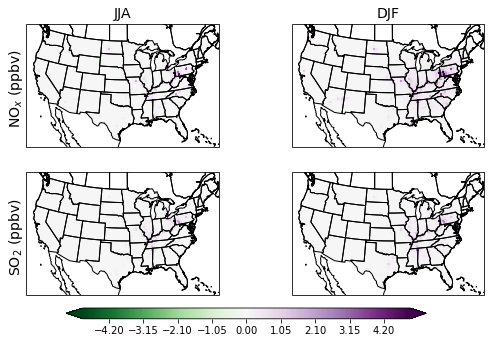

In [7]:
plotting.concentration_plot_seasonal_dif(ds_seasonal = ds_seasonal, seasons = ['JJA','DJF'], species_names = ['NOx','SO2'], cmap = plotting.cmap_dif, 
                                         mod_base = 'normal_NA', mod_delta = 'nonuc_NA',
                   rows = 2, columns = 2, levels = np.arange(-5.,5.05,.05), lat_lon = plotting.lat_lon,
                   figsize = [10, 5], extension = 'both')
plt.savefig('./Figures/nox_so2_dif_nonuc.png', bbox_inches = 'tight', dpi = 150)

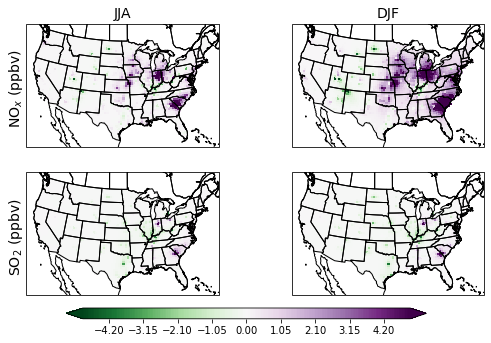

In [8]:
plotting.concentration_plot_seasonal_dif(ds_seasonal = ds_seasonal, seasons = ['JJA','DJF'], species_names = ['NOx','SO2'], cmap = plotting.cmap_dif, 
                                         mod_base = 'normal_NA', mod_delta = 'nonuc_coal_NA',
                   rows = 2, columns = 2, levels = np.arange(-5.,5.05,.05), lat_lon = plotting.lat_lon,
                   figsize = [10, 5], extension = 'both')
plt.savefig('./Figures/nox_so2_dif_nocoal.png', bbox_inches = 'tight', dpi = 150)

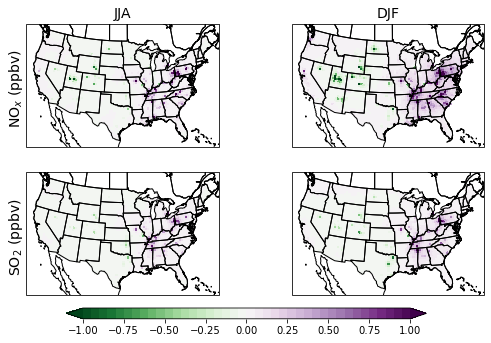

In [9]:
plotting.concentration_plot_seasonal_dif(ds_seasonal = ds_seasonal, seasons = ['JJA','DJF'], species_names = ['NOx','SO2'], cmap = plotting.cmap_dif, 
                                         mod_base = 'normal_NA', mod_delta = 'renew_nonuc_NA',
                   rows = 2, columns = 2, levels = np.arange(-1.,1.05,.05), lat_lon = plotting.lat_lon,
                   figsize = [10, 5], extension = 'both')
plt.savefig('./Figures/nox_so2_dif_renew.png', bbox_inches = 'tight', dpi = 150)

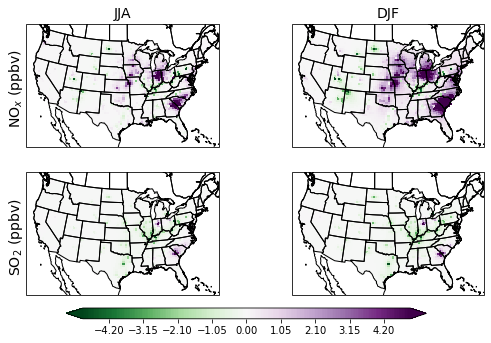

In [10]:
plotting.concentration_plot_seasonal_dif(ds_seasonal = ds_seasonal, seasons = ['JJA','DJF'], species_names = ['NOx','SO2'], cmap = plotting.cmap_dif, 
                                         mod_base = 'nonuc_NA', mod_delta = 'nonuc_coal_NA',
                   rows = 2, columns = 2, levels = np.arange(-5.,5.05,.05), lat_lon = plotting.lat_lon,
                   figsize = [10, 5], extension = 'both')
#plt.savefig('./Figures/nox_so2_dif_nocoal.png', bbox_inches = 'tight', dpi = 150)

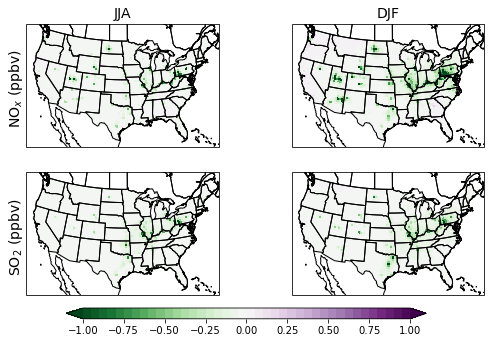

In [11]:
plotting.concentration_plot_seasonal_dif(ds_seasonal = ds_seasonal, seasons = ['JJA','DJF'], species_names = ['NOx','SO2'], cmap = plotting.cmap_dif, 
                                         mod_base = 'nonuc_NA', mod_delta = 'renew_nonuc_NA',
                   rows = 2, columns = 2, levels = np.arange(-1.,1.05,.05), lat_lon = plotting.lat_lon,
                   figsize = [10, 5], extension = 'both')
#plt.savefig('./Figures/nox_so2_dif_nocoal.png', bbox_inches = 'tight', dpi = 150)